# Modelo Predictivo PTJE_NEM
## Predicción del puntaje NEM basado en puntajes PAES
### Variables: MATE1_INV_ACTUAL + CLEC_INV_ACTUAL → PTJE_NEM
### Datos 2023-2025

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Config visualizacion
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Carga de Datos

In [2]:
# Años a analizar
años = [2023, 2024, 2025]

# Lista para almacenar dataframes
adm = []

# Cargar datos
for año in años:
    try:
        # Buscar archivos CSV
        ruta = Path(f'raw_data/{año}')
        archivos = list(ruta.glob(f'**/ArchivoC_Adm{año}*.csv'))
        
        if archivos:
            df = pd.read_csv(archivos[0], sep=';', low_memory=False)
            df['ANIO'] = año
            adm.append(df)
            print(f"✓ Datos {año} cargados: {df.shape[0]} registros")
        else:
            print(f"✗ No se encontraron archivos para {año}")
    except Exception as e:
        print(f"Error cargando {año}: {e}")

# Verificar
print(f"\nTotal dataframes cargados: {len(adm)}")

✓ Datos 2023 cargados: 293865 registros
✓ Datos 2024 cargados: 306497 registros
✓ Datos 2025 cargados: 311084 registros

Total dataframes cargados: 3


In [3]:
# Concatenar todos los años
if len(adm) > 0:
    df_completo = pd.concat(adm, ignore_index=True)
    print(f"Dataset completo: {df_completo.shape}")
    df_completo.head()

Dataset completo: (911446, 39)


In [4]:
df_completo.columns

Index(['ID_aux', 'RBD', 'COD_ENS', 'GRUPO_DEPENDENCIA', 'RAMA_EDUCACIONAL',
       'SITUACION_EGRESO', 'CODIGO_REGION', 'CODIGO_COMUNA', 'PROMEDIO_NOTAS',
       'PORC_SUP_NOTAS', 'PTJE_NEM', 'PTJE_RANKING', 'CLEC_REG_ACTUAL',
       'MATE1_REG_ACTUAL', 'MATE2_REG_ACTUAL', 'HCSOC_REG_ACTUAL',
       'CIEN_REG_ACTUAL', 'MODULO_REG_ACTUAL', 'CLEC_INV_ACTUAL',
       'MATE_INV_ACTUAL', 'HCSOC_INV_ACTUAL', 'CIEN_INV_ACTUAL',
       'MODULO_INV_ACTUAL', 'CLEC_REG_ANTERIOR', 'MATE1_REG_ANTERIOR',
       'HCSOC_REG_ANTERIOR', 'CIEN_REG_ANTERIOR', 'MODULO_REG_ANTERIOR',
       'ANIO', 'MATE1_INV_ACTUAL', 'MATE2_INV_ACTUAL', 'MATE2_REG_ANTERIOR',
       'CLEC_INV_ANTERIOR', 'MATE_INV_ANTERIOR', 'HCSOC_INV_ANTERIOR',
       'CIEN_INV_ANTERIOR', 'MODULO_INV_ANTERIOR', 'MATE1_INV_ANTERIOR',
       'MATE2_INV_ANTERIOR'],
      dtype='object')

## 2. Selección y Limpieza de Variables

In [5]:
df_completo.columns

Index(['ID_aux', 'RBD', 'COD_ENS', 'GRUPO_DEPENDENCIA', 'RAMA_EDUCACIONAL',
       'SITUACION_EGRESO', 'CODIGO_REGION', 'CODIGO_COMUNA', 'PROMEDIO_NOTAS',
       'PORC_SUP_NOTAS', 'PTJE_NEM', 'PTJE_RANKING', 'CLEC_REG_ACTUAL',
       'MATE1_REG_ACTUAL', 'MATE2_REG_ACTUAL', 'HCSOC_REG_ACTUAL',
       'CIEN_REG_ACTUAL', 'MODULO_REG_ACTUAL', 'CLEC_INV_ACTUAL',
       'MATE_INV_ACTUAL', 'HCSOC_INV_ACTUAL', 'CIEN_INV_ACTUAL',
       'MODULO_INV_ACTUAL', 'CLEC_REG_ANTERIOR', 'MATE1_REG_ANTERIOR',
       'HCSOC_REG_ANTERIOR', 'CIEN_REG_ANTERIOR', 'MODULO_REG_ANTERIOR',
       'ANIO', 'MATE1_INV_ACTUAL', 'MATE2_INV_ACTUAL', 'MATE2_REG_ANTERIOR',
       'CLEC_INV_ANTERIOR', 'MATE_INV_ANTERIOR', 'HCSOC_INV_ANTERIOR',
       'CIEN_INV_ANTERIOR', 'MODULO_INV_ANTERIOR', 'MATE1_INV_ANTERIOR',
       'MATE2_INV_ANTERIOR'],
      dtype='object')

In [6]:
# Seleccionar columnas relevantes: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL, PTJE_NEM
columnas = ['ID_aux', 'MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM', 'ANIO']

# Verificar que existan las columnas
columnas_disponibles = [col for col in columnas if col in df_completo.columns]
print(f"Columnas disponibles: {columnas_disponibles}")

# Crear dataset de trabajo
df = df_completo[columnas_disponibles].copy()

# Info inicial
print(f"\nDatos antes de limpieza: {df.shape}")
df.info()

Columnas disponibles: ['ID_aux', 'PROMEDIO_NOTAS', 'PTJE_NEM', 'ANIO']

Datos antes de limpieza: (911446, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911446 entries, 0 to 911445
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID_aux          911446 non-null  object
 1   PROMEDIO_NOTAS  911446 non-null  object
 2   PTJE_NEM        911446 non-null  int64 
 3   ANIO            911446 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 27.8+ MB


In [7]:
df

,ID_aux,PROMEDIO_NOTAS,PTJE_NEM,ANIO
0,id_0000900170003,"5,03",429,2023
1,id_0000900470024,"5,9",689,2023
2,id_0000900670068,5,415,2023
3,id_0001900070103,"5,6",599,2023
4,id_0001900070149,"5,28",506,2023
...,...,...,...,...
911441,id_5995599440825,0,0,2025
911442,id_4895488246247,0,0,2025
911443,id_9866988747313,"6,28",793,2025
911444,id_5866598447255,"5,68",622,2025


In [8]:
# Limpieza de datos
# Eliminar nulos
df = df.dropna(subset=['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM'])

# Convertir a numérico
df['MATE1_INV_ACTUAL'] = pd.to_numeric(df['MATE1_INV_ACTUAL'], errors='coerce')
df['CLEC_INV_ACTUAL'] = pd.to_numeric(df['CLEC_INV_ACTUAL'], errors='coerce')
df['PTJE_NEM'] = pd.to_numeric(df['PTJE_NEM'], errors='coerce')

# Eliminar NaN después de conversión
df = df.dropna(subset=['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PTJE_NEM'])

# Crear variable PROM_PAES (promedio de MATE1 y CLEC)
df['PROM_PAES'] = (df['MATE1_INV_ACTUAL'] + df['CLEC_INV_ACTUAL']) / 2

# Eliminar valores <= 0 o fuera de rango razonable
# Puntajes PAES van de 100 a 1000
df = df[(df['MATE1_INV_ACTUAL'] > 100) & (df['MATE1_INV_ACTUAL'] <= 1000)]
df = df[(df['CLEC_INV_ACTUAL'] > 100) & (df['CLEC_INV_ACTUAL'] <= 1000)]
df = df[(df['PTJE_NEM'] > 0) & (df['PTJE_NEM'] <= 1000)]

# Eliminar outliers extremos (percentil 1% y 99%)
Q1_mate = df['MATE1_INV_ACTUAL'].quantile(0.01)
Q3_mate = df['MATE1_INV_ACTUAL'].quantile(0.99)
Q1_clec = df['CLEC_INV_ACTUAL'].quantile(0.01)
Q3_clec = df['CLEC_INV_ACTUAL'].quantile(0.99)
Q1_ptje = df['PTJE_NEM'].quantile(0.01)
Q3_ptje = df['PTJE_NEM'].quantile(0.99)

df = df[(df['MATE1_INV_ACTUAL'] >= Q1_mate) & (df['MATE1_INV_ACTUAL'] <= Q3_mate)]
df = df[(df['CLEC_INV_ACTUAL'] >= Q1_clec) & (df['CLEC_INV_ACTUAL'] <= Q3_clec)]
df = df[(df['PTJE_NEM'] >= Q1_ptje) & (df['PTJE_NEM'] <= Q3_ptje)]

print(f"Datos después de limpieza: {df.shape}")
print(f"Registros eliminados: {df_completo.shape[0] - df.shape[0]}")
print(f"Porcentaje de datos conservados: {df.shape[0]/df_completo.shape[0]*100:.1f}%")

Datos después de limpieza: (20282, 4)
Registros eliminados: 891164


## 3. Análisis Exploratorio

In [9]:
# Estadísticas descriptivas
df[['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PROM_PAES', 'PTJE_NEM']].describe()

,PROMEDIO_NOTAS,PTJE_NEM
count,20282.000000,20282.000000
mean,5.849325,668.434178
std,0.497196,146.127004
min,5.000000,415.000000
25%,6.000000,713.000000
50%,6.000000,713.000000
75%,6.000000,715.000000
max,7.000000,1000.000000


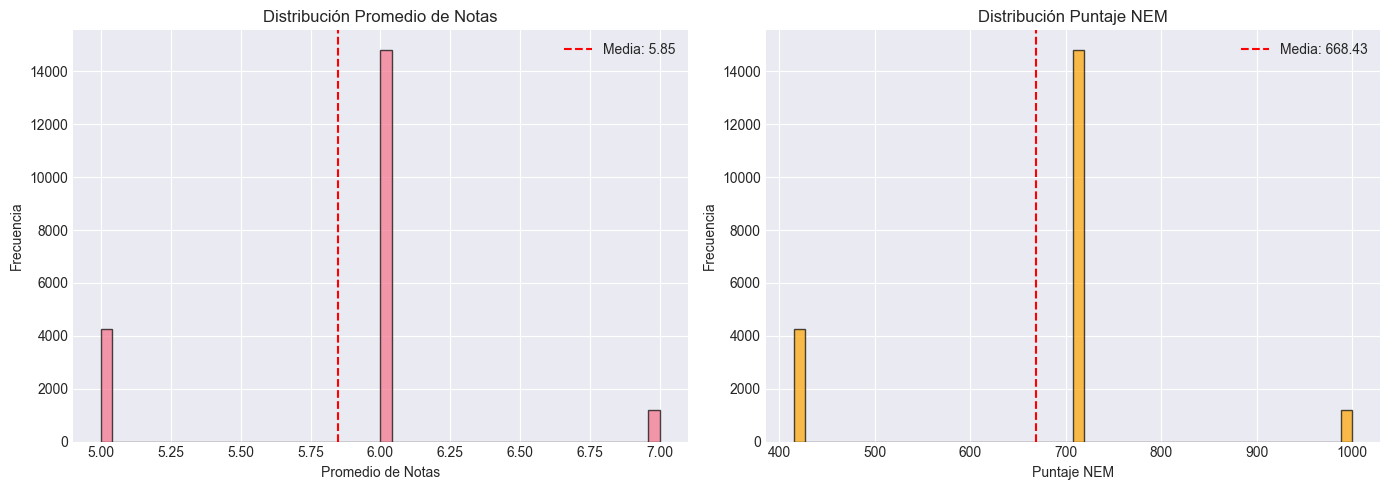

In [11]:
# Distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MATE1_INV_ACTUAL
axes[0, 0].hist(df['MATE1_INV_ACTUAL'], bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Puntaje Matemática 1')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución MATE1_INV_ACTUAL')
axes[0, 0].axvline(df['MATE1_INV_ACTUAL'].mean(), color='red', linestyle='--', 
                    label=f'Media: {df["MATE1_INV_ACTUAL"].mean():.1f}')
axes[0, 0].legend()

# CLEC_INV_ACTUAL
axes[0, 1].hist(df['CLEC_INV_ACTUAL'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Puntaje Comprensión Lectora')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución CLEC_INV_ACTUAL')
axes[0, 1].axvline(df['CLEC_INV_ACTUAL'].mean(), color='red', linestyle='--', 
                    label=f'Media: {df["CLEC_INV_ACTUAL"].mean():.1f}')
axes[0, 1].legend()

# Promedio PAES
axes[1, 0].hist(df['PROM_PAES'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_xlabel('Promedio PAES')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución Promedio PAES')
axes[1, 0].axvline(df['PROM_PAES'].mean(), color='red', linestyle='--', 
                    label=f'Media: {df["PROM_PAES"].mean():.1f}')
axes[1, 0].legend()

# Puntaje NEM
axes[1, 1].hist(df['PTJE_NEM'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Puntaje NEM')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución PTJE_NEM')
axes[1, 1].axvline(df['PTJE_NEM'].mean(), color='red', linestyle='--', 
                    label=f'Media: {df["PTJE_NEM"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Matriz de Correlación:
                PROMEDIO_NOTAS  PTJE_NEM
PROMEDIO_NOTAS        1.000000  0.999863
PTJE_NEM              0.999863  1.000000


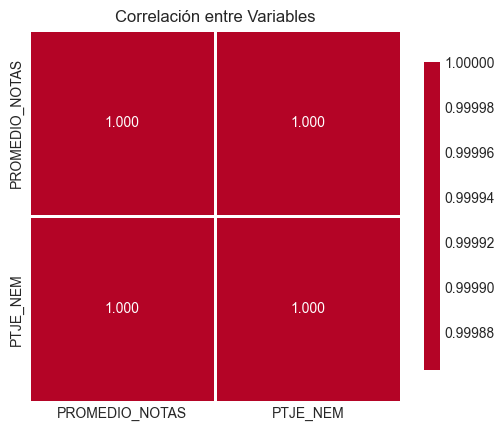

In [12]:
# Correlación
correlacion = df[['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL', 'PROM_PAES', 'PTJE_NEM']].corr()
print("Matriz de Correlación:")
print(correlacion)

plt.figure(figsize=(8, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlación entre Variables')
plt.show()

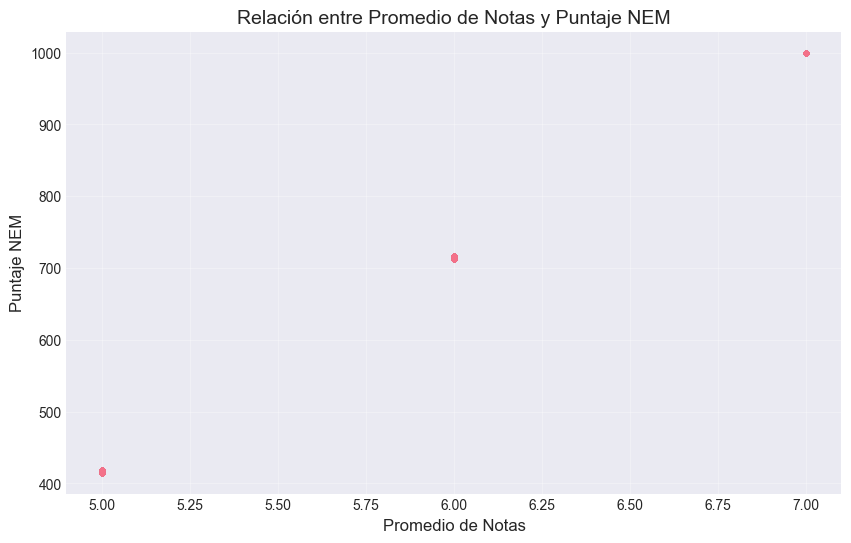

In [13]:
# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MATE1 vs PTJE_NEM
axes[0].scatter(df['MATE1_INV_ACTUAL'], df['PTJE_NEM'], alpha=0.3, s=10, color='blue')
axes[0].set_xlabel('MATE1_INV_ACTUAL', fontsize=11)
axes[0].set_ylabel('PTJE_NEM', fontsize=11)
axes[0].set_title('MATE1 vs PTJE_NEM', fontsize=12)
axes[0].grid(True, alpha=0.3)

# CLEC vs PTJE_NEM
axes[1].scatter(df['CLEC_INV_ACTUAL'], df['PTJE_NEM'], alpha=0.3, s=10, color='green')
axes[1].set_xlabel('CLEC_INV_ACTUAL', fontsize=11)
axes[1].set_ylabel('PTJE_NEM', fontsize=11)
axes[1].set_title('CLEC vs PTJE_NEM', fontsize=12)
axes[1].grid(True, alpha=0.3)

# PROM_PAES vs PTJE_NEM
axes[2].scatter(df['PROM_PAES'], df['PTJE_NEM'], alpha=0.3, s=10, color='purple')
axes[2].set_xlabel('PROM_PAES', fontsize=11)
axes[2].set_ylabel('PTJE_NEM', fontsize=11)
axes[2].set_title('Promedio PAES vs PTJE_NEM', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Preparación de Datos para Modelado

In [14]:
# Variables independientes (X) y dependiente (y)
# Usamos MATE1_INV_ACTUAL y CLEC_INV_ACTUAL como predictores
X = df[['MATE1_INV_ACTUAL', 'CLEC_INV_ACTUAL']].values
y = df['PTJE_NEM'].values

# También guardamos el promedio PAES para análisis
X_prom = df[['PROM_PAES']].values

# Split train-test (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_prom_train, X_prom_test, _, _ = train_test_split(X_prom, y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")
print(f"Features: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL")

Datos de entrenamiento: (16225, 1)
Datos de prueba: (4057, 1)


## 5. Modelos de Regresión

### 5.1 Regresión Lineal Múltiple (MATE1 + CLEC)

In [ ]:
# Entrenar modelo con MATE1 + CLEC
lr_multiple = LinearRegression()
lr_multiple.fit(X_train, y_train)

# Predicciones
y_pred_train_lr = lr_multiple.predict(X_train)
y_pred_test_lr = lr_multiple.predict(X_test)

# Métricas
r2_train_lr = r2_score(y_train, y_pred_train_lr)
r2_test_lr = r2_score(y_test, y_pred_test_lr)
mse_lr = mean_squared_error(y_test, y_pred_test_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_test_lr)

print("=== Regresión Lineal Múltiple (MATE1 + CLEC) ===")
print(f"Coeficiente MATE1: {lr_multiple.coef_[0]:.4f}")
print(f"Coeficiente CLEC: {lr_multiple.coef_[1]:.4f}")
print(f"Intercepto: {lr_multiple.intercept_:.4f}")
print(f"\nEcuación: PTJE_NEM = {lr_multiple.coef_[0]:.4f}*MATE1 + {lr_multiple.coef_[1]:.4f}*CLEC + {lr_multiple.intercept_:.4f}")
print(f"\nR² (train): {r2_train_lr:.4f}")
print(f"R² (test): {r2_test_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

=== Regresión Lineal Simple ===
Coeficiente: 293.8727
Intercepto: -1050.5225

R² (train): 0.9997
R² (test): 0.9997
MSE: 5.9052
RMSE: 2.4301
MAE: 1.5929


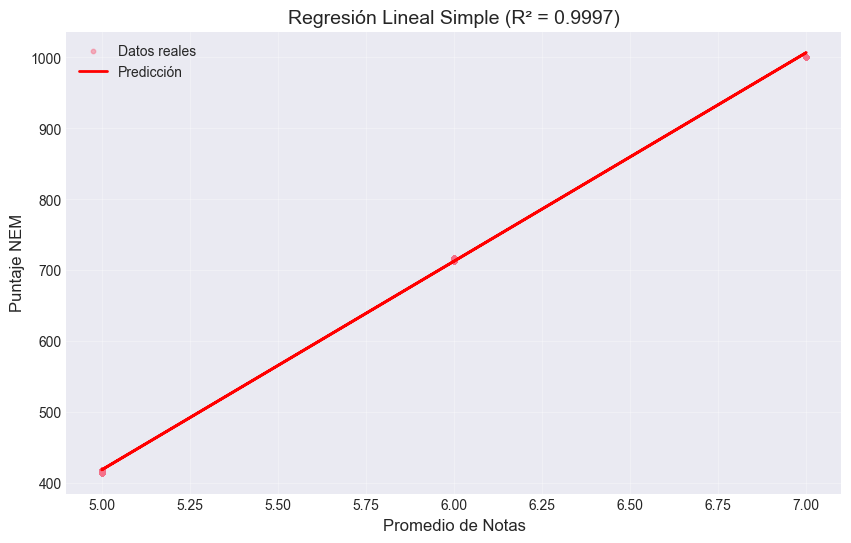

In [16]:
# Visualización: Valores reales vs predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lr, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción perfecta')
plt.xlabel('PTJE_NEM Real', fontsize=12)
plt.ylabel('PTJE_NEM Predicho', fontsize=12)
plt.title(f'Regresión Lineal Múltiple (R² = {r2_test_lr:.4f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 5.2 Regresión Polinomial

In [17]:
# Probar diferentes grados con MATE1 + CLEC
grados = [2, 3]
resultados_poly = {}

for grado in grados:
    # Crear features polinomiales
    poly = PolynomialFeatures(degree=grado, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Entrenar modelo
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)
    
    # Predicciones
    y_pred_train_poly = lr_poly.predict(X_train_poly)
    y_pred_test_poly = lr_poly.predict(X_test_poly)
    
    # Métricas
    r2_train = r2_score(y_train, y_pred_train_poly)
    r2_test = r2_score(y_test, y_pred_test_poly)
    mse = mean_squared_error(y_test, y_pred_test_poly)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test_poly)
    
    resultados_poly[grado] = {
        'modelo': lr_poly,
        'poly': poly,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'y_pred': y_pred_test_poly
    }
    
    print(f"\n=== Regresión Polinomial (Grado {grado}) ===")
    print(f"Features generados: {X_train_poly.shape[1]}")
    print(f"R² (train): {r2_train:.4f}")
    print(f"R² (test): {r2_test:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


=== Regresión Polinomial (Grado 2) ===
R² (train): 0.9999
R² (test): 0.9999
MSE: 1.7041
RMSE: 1.3054
MAE: 1.1179

=== Regresión Polinomial (Grado 3) ===
R² (train): 0.9999
R² (test): 0.9999
MSE: 1.7041
RMSE: 1.3054
MAE: 1.1179

=== Regresión Polinomial (Grado 4) ===
R² (train): 0.9999
R² (test): 0.9999
MSE: 1.7041
RMSE: 1.3054
MAE: 1.1179


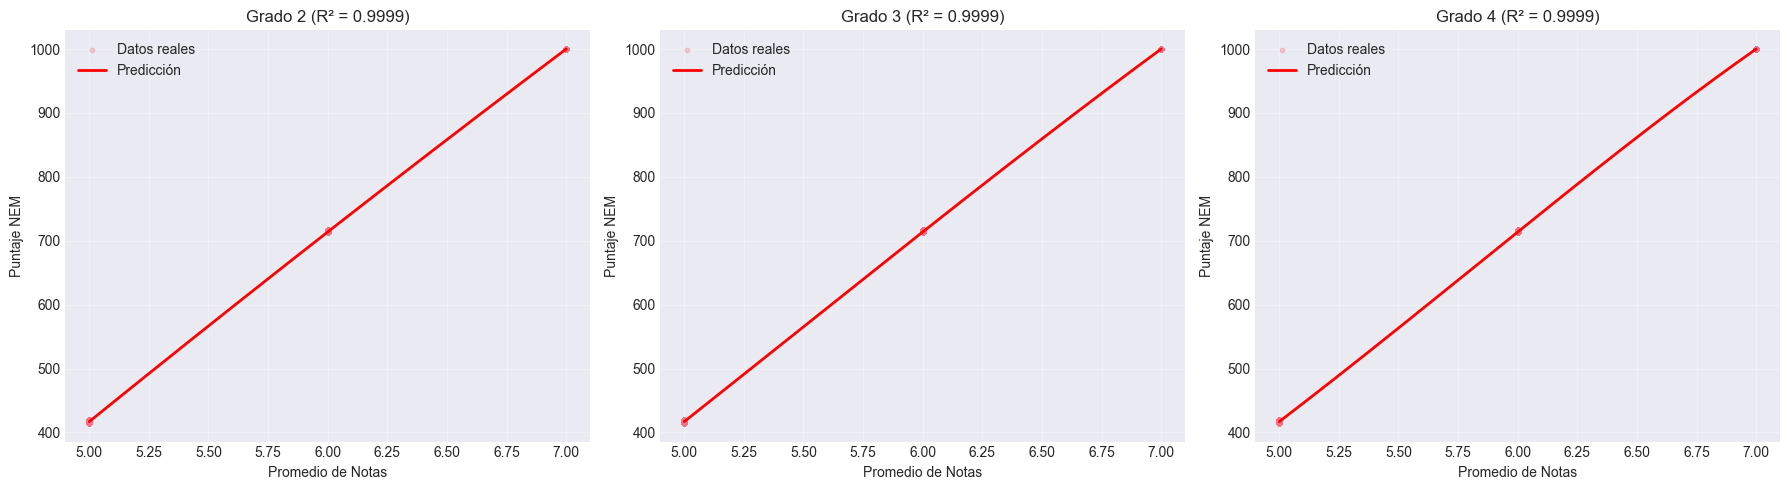

In [18]:
# Visualizar diferentes grados - Real vs Predicho
fig, axes = plt.subplots(1, len(grados), figsize=(12, 5))

for idx, grado in enumerate(grados):
    y_pred_poly = resultados_poly[grado]['y_pred']
    
    # Plot
    axes[idx].scatter(y_test, y_pred_poly, alpha=0.3, s=10)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfecta')
    axes[idx].set_xlabel('PTJE_NEM Real')
    axes[idx].set_ylabel('PTJE_NEM Predicho')
    axes[idx].set_title(f'Grado {grado} (R² = {resultados_poly[grado]["r2_test"]:.4f})')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Regresión Ridge (Regularización L2)

In [19]:
# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Probar diferentes alphas
alphas = [0.1, 1.0, 10.0, 100.0]
resultados_ridge = {}

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    y_pred_train_ridge = ridge.predict(X_train_scaled)
    y_pred_test_ridge = ridge.predict(X_test_scaled)
    
    r2_train = r2_score(y_train, y_pred_train_ridge)
    r2_test = r2_score(y_test, y_pred_test_ridge)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
    
    resultados_ridge[alpha] = {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse': rmse
    }
    
    print(f"Alpha={alpha}: R² train={r2_train:.4f}, R² test={r2_test:.4f}, RMSE={rmse:.4f}")

Alpha=0.1: R² train=0.9997, R² test=0.9997, RMSE=2.4301
Alpha=1.0: R² train=0.9997, R² test=0.9997, RMSE=2.4300
Alpha=10.0: R² train=0.9997, R² test=0.9997, RMSE=2.4308
Alpha=100.0: R² train=0.9997, R² test=0.9997, RMSE=2.5836


### 5.4 Regresión Lasso (Regularización L1)

In [20]:
# Probar diferentes alphas
resultados_lasso = {}

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    
    y_pred_train_lasso = lasso.predict(X_train_scaled)
    y_pred_test_lasso = lasso.predict(X_test_scaled)
    
    r2_train = r2_score(y_train, y_pred_train_lasso)
    r2_test = r2_score(y_test, y_pred_test_lasso)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
    
    resultados_lasso[alpha] = {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse': rmse
    }
    
    print(f"Alpha={alpha}: R² train={r2_train:.4f}, R² test={r2_test:.4f}, RMSE={rmse:.4f}")

Alpha=0.1: R² train=0.9997, R² test=0.9997, RMSE=2.4311
Alpha=1.0: R² train=0.9997, R² test=0.9997, RMSE=2.6225
Alpha=10.0: R² train=0.9950, R² test=0.9950, RMSE=10.3824
Alpha=100.0: R² train=0.5292, R² test=0.5292, RMSE=101.2005


## 6. Comparación de Modelos


=== COMPARACIÓN DE MODELOS ===
            Modelo  R² Train  R² Test     RMSE      MAE
Polinomial Grado 4  0.999921 0.999922 1.305401 1.117888
Polinomial Grado 3  0.999921 0.999922 1.305401 1.117888
Polinomial Grado 2  0.999921 0.999922 1.305401 1.117888
     Lineal Simple  0.999726 0.999729 2.430069 1.592949


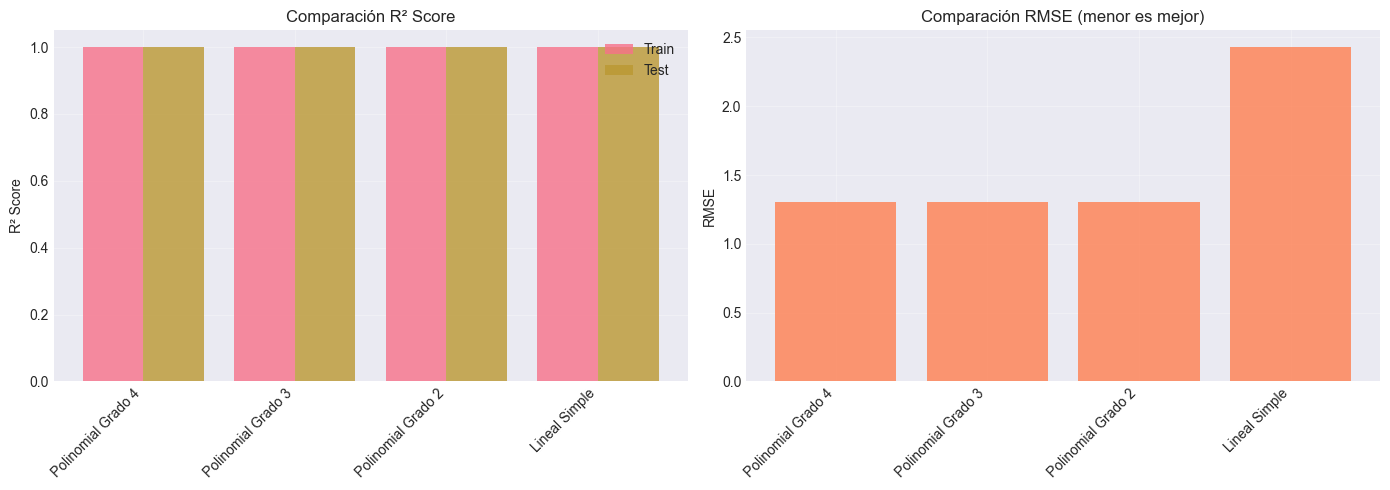

In [21]:
# Resumen de resultados
modelos_lista = ['Lineal Múltiple']
r2_train_lista = [r2_train_lr]
r2_test_lista = [r2_test_lr]
rmse_lista = [rmse_lr]
mae_lista = [mae_lr]

for grado in grados:
    modelos_lista.append(f'Polinomial Grado {grado}')
    r2_train_lista.append(resultados_poly[grado]['r2_train'])
    r2_test_lista.append(resultados_poly[grado]['r2_test'])
    rmse_lista.append(resultados_poly[grado]['rmse'])
    mae_lista.append(resultados_poly[grado]['mae'])

comparacion = pd.DataFrame({
    'Modelo': modelos_lista,
    'R² Train': r2_train_lista,
    'R² Test': r2_test_lista,
    'RMSE': rmse_lista,
    'MAE': mae_lista
})

comparacion = comparacion.sort_values('R² Test', ascending=False)
print("\n=== COMPARACIÓN DE MODELOS ===")
print(comparacion.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Score
x_pos = np.arange(len(comparacion))
axes[0].bar(x_pos - 0.2, comparacion['R² Train'], 0.4, label='Train', alpha=0.8)
axes[0].bar(x_pos + 0.2, comparacion['R² Test'], 0.4, label='Test', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparacion['Modelo'], rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación R² Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE
axes[1].bar(x_pos, comparacion['RMSE'], alpha=0.8, color='coral')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparacion['Modelo'], rotation=45, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparación RMSE (menor es mejor)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Análisis de Residuos (Mejor Modelo)

In [22]:
# Seleccionar mejor modelo (mayor R² test)
mejor_modelo_nombre = comparacion.iloc[0]['Modelo']
print(f"Mejor modelo: {mejor_modelo_nombre}")

# Obtener predicciones del mejor modelo
if 'Múltiple' in mejor_modelo_nombre:
    y_pred_mejor = y_pred_test_lr
    mejor_modelo = lr_multiple
else:
    grado_mejor = int(mejor_modelo_nombre.split()[-1])
    y_pred_mejor = resultados_poly[grado_mejor]['y_pred']
    mejor_modelo = resultados_poly[grado_mejor]['modelo']

# Calcular residuos
residuos = y_test - y_pred_mejor

Mejor modelo: Polinomial Grado 4


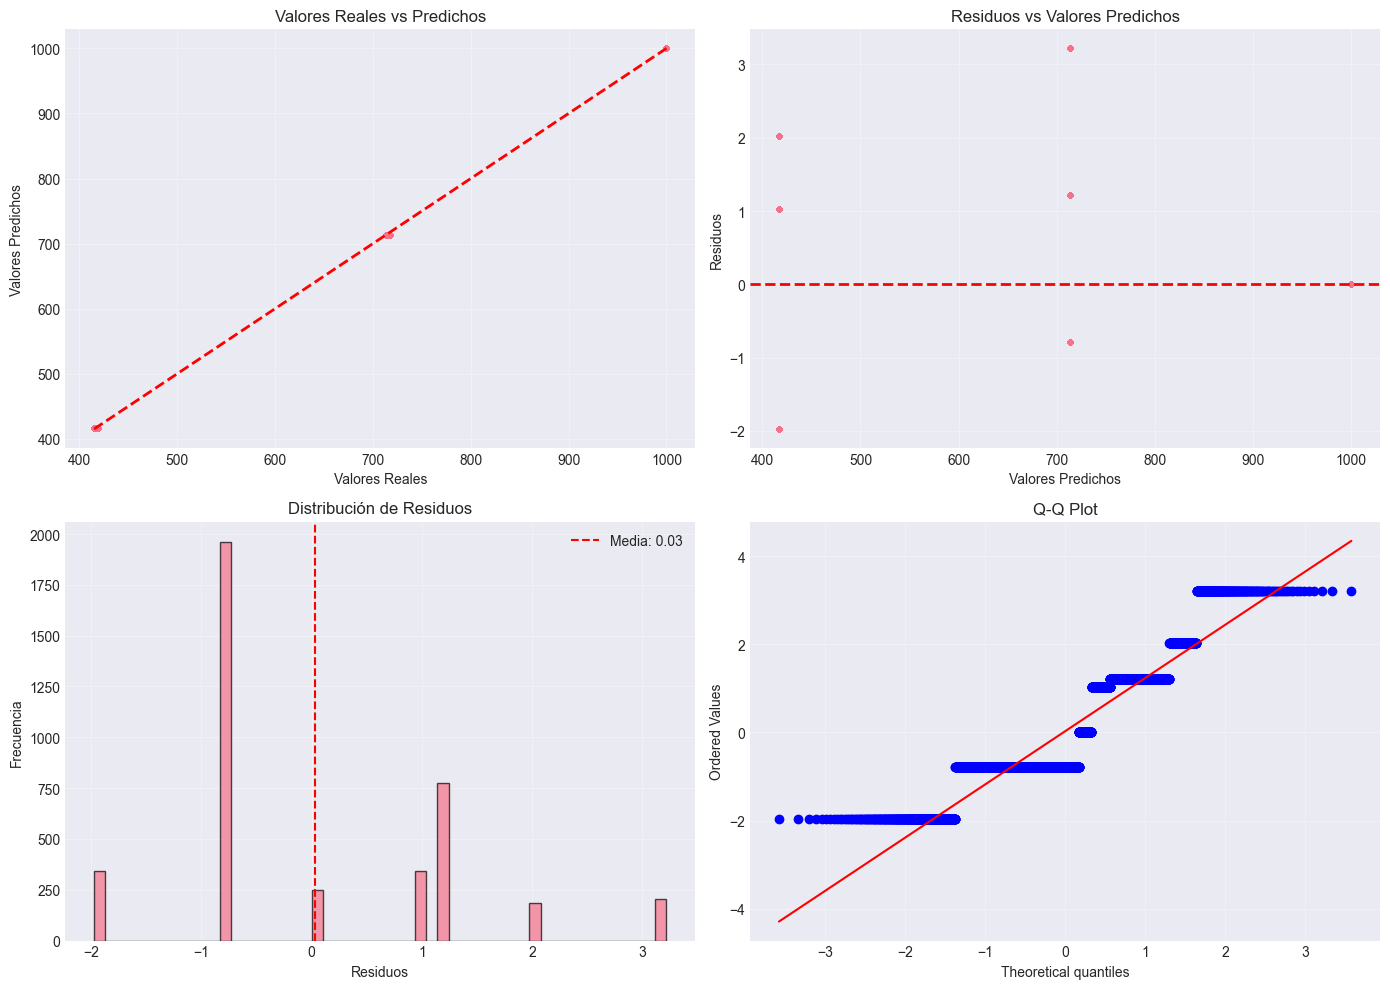


=== ESTADÍSTICAS DE RESIDUOS ===
Media: 0.0285
Desviación estándar: 1.3051
Min: -1.9741
Max: 3.2188


In [23]:
# Gráficos de residuos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Valores reales vs predichos
axes[0, 0].scatter(y_test, y_pred_mejor, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Valores Predichos')
axes[0, 0].set_title('Valores Reales vs Predichos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs valores predichos
axes[0, 1].scatter(y_pred_mejor, residuos, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valores Predichos')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].set_title('Residuos vs Valores Predichos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución de residuos
axes[1, 0].hist(residuos, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')
axes[1, 0].axvline(residuos.mean(), color='r', linestyle='--', label=f'Media: {residuos.mean():.2f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot
from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print("\n=== ESTADÍSTICAS DE RESIDUOS ===")
print(f"Media: {residuos.mean():.4f}")
print(f"Desviación estándar: {residuos.std():.4f}")
print(f"Min: {residuos.min():.4f}")
print(f"Max: {residuos.max():.4f}")

## 8. Predicciones de Ejemplo

In [24]:
# Ejemplos de predicción
# Puntajes de ejemplo: [MATE1, CLEC]
ejemplos = np.array([
    [400, 400],  # Bajo
    [500, 500],  # Medio-Bajo
    [600, 600],  # Medio
    [700, 700],  # Medio-Alto
    [800, 800],  # Alto
    [600, 700],  # MATE bajo, CLEC alto
    [700, 600]   # MATE alto, CLEC bajo
])

print("\n=== PREDICCIONES DE EJEMPLO ===")
print(f"Usando modelo: {mejor_modelo_nombre}\n")

if 'Múltiple' in mejor_modelo_nombre:
    predicciones = lr_multiple.predict(ejemplos)
else:
    grado_mejor = int(mejor_modelo_nombre.split()[-1])
    ejemplos_poly = resultados_poly[grado_mejor]['poly'].transform(ejemplos)
    predicciones = resultados_poly[grado_mejor]['modelo'].predict(ejemplos_poly)

print(f"{'MATE1':<8} {'CLEC':<8} {'Prom PAES':<12} → {'PTJE_NEM Predicho':<20}")
print("="*60)
for (mate, clec), pred in zip(ejemplos, predicciones):
    prom_paes = (mate + clec) / 2
    print(f"{mate:<8.0f} {clec:<8.0f} {prom_paes:<12.1f} → {pred:<20.2f}")


=== PREDICCIONES DE EJEMPLO ===
Usando modelo: Polinomial Grado 4

Promedio Notas: 5.0 → Puntaje NEM Predicho: 416.97
Promedio Notas: 5.5 → Puntaje NEM Predicho: 563.41
Promedio Notas: 6.0 → Puntaje NEM Predicho: 713.78
Promedio Notas: 6.5 → Puntaje NEM Predicho: 861.78
Promedio Notas: 7.0 → Puntaje NEM Predicho: 1000.00


## 9. Conclusiones

In [26]:
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)
print(f"\nDatos analizados: {df.shape[0]:,} estudiantes (años 2023-2025)")
print(f"\nVariables predictoras: MATE1_INV_ACTUAL, CLEC_INV_ACTUAL")
print(f"Variable objetivo: PTJE_NEM")
print(f"\nMejor modelo: {mejor_modelo_nombre}")
print(f"R² en test: {comparacion.iloc[0]['R² Test']:.4f}")
print(f"RMSE: {comparacion.iloc[0]['RMSE']:.4f}")
print(f"MAE: {comparacion.iloc[0]['MAE']:.4f}")
print(f"\nCorrelaciones con PTJE_NEM:")
print(f"  - MATE1_INV_ACTUAL: {df[['MATE1_INV_ACTUAL', 'PTJE_NEM']].corr().iloc[0, 1]:.4f}")
print(f"  - CLEC_INV_ACTUAL: {df[['CLEC_INV_ACTUAL', 'PTJE_NEM']].corr().iloc[0, 1]:.4f}")
print(f"  - PROM_PAES: {df[['PROM_PAES', 'PTJE_NEM']].corr().iloc[0, 1]:.4f}")
print("\n" + "="*70)


RESUMEN FINAL

Datos analizados: 20282 estudiantes (años 2023-2025)

Mejor modelo: Polinomial Grado 4
R² en test: 0.9999
RMSE: 1.3054
MAE: 1.1179

Correlación PROM_NOTAS vs PTJE_NEM: 0.9999

